In [34]:
import torch
import data_s2s
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import pdb

snapshot_scratch = "/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-07-27_18-08-35/snapshot_0.pt"
r3m_scratch = load_r3m('resnet50', snapshot_scratch).to('cuda:0')
r3m_scratch.eval()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- T

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [31]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_rlbench(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)
    
def show_images_ego4d(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)

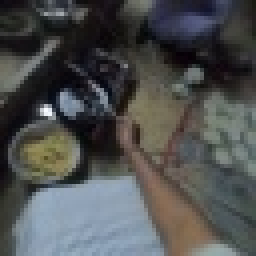

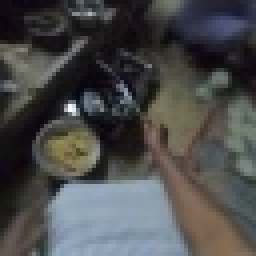

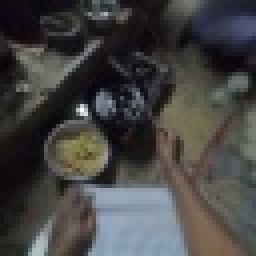

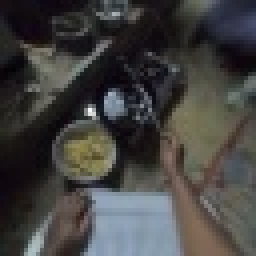

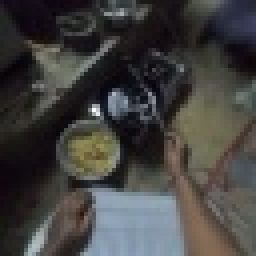

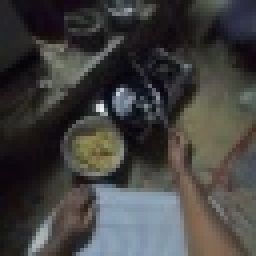

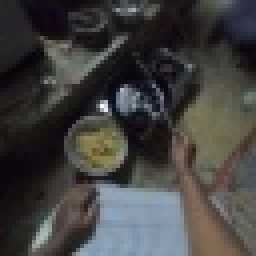

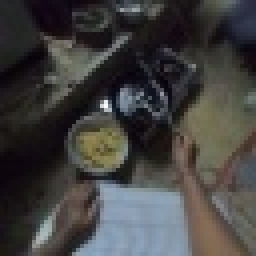

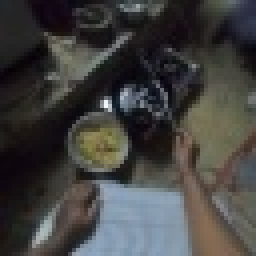

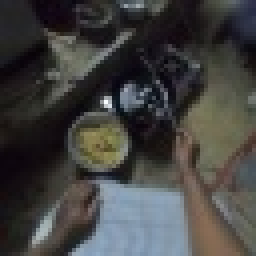

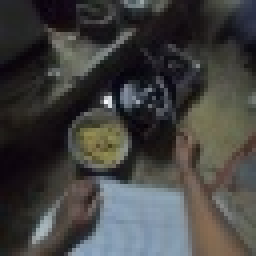

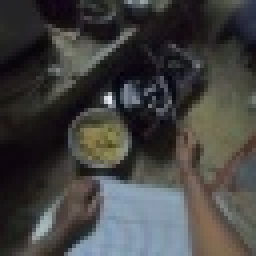

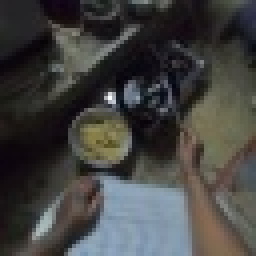

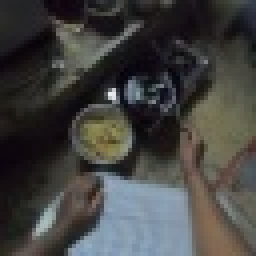

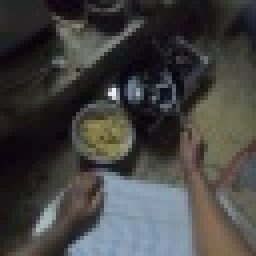

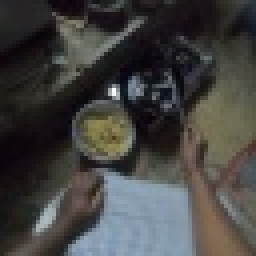

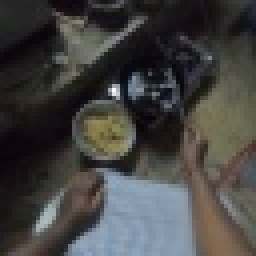

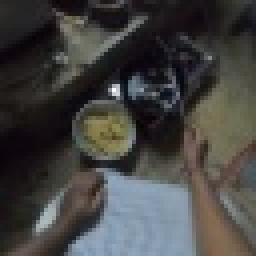

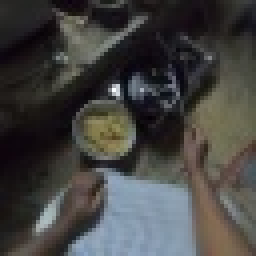

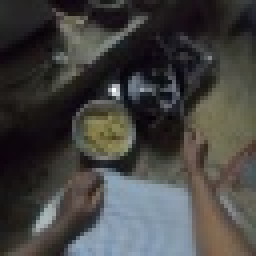

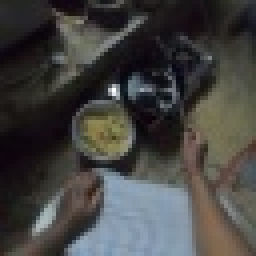

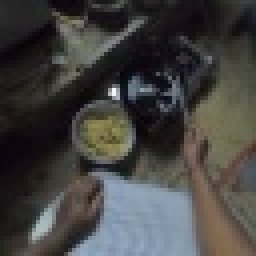

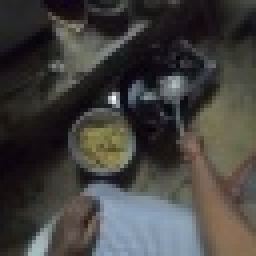

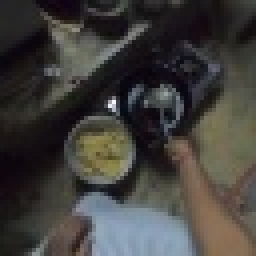

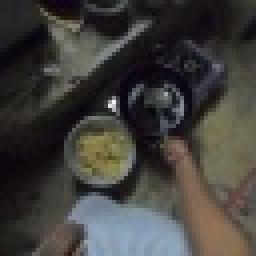

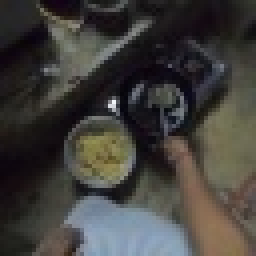

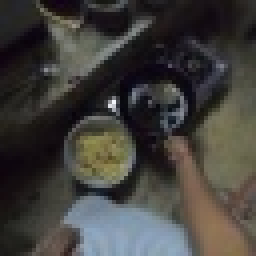

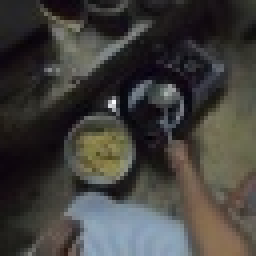

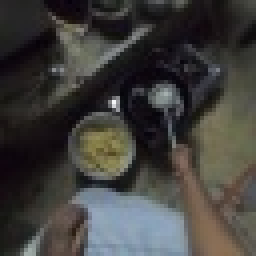

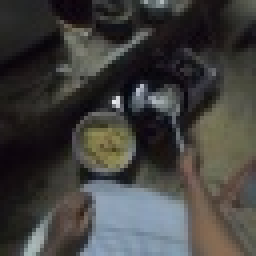

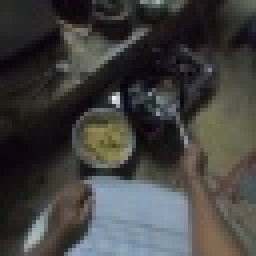

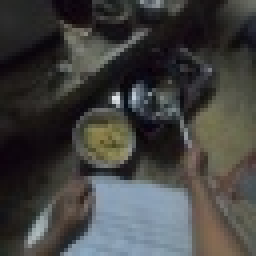

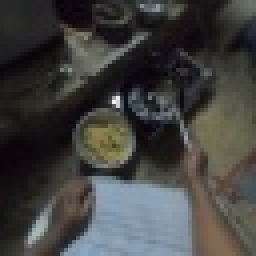

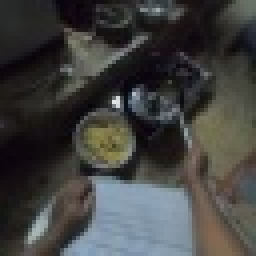

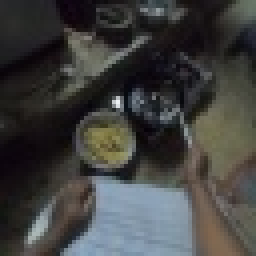

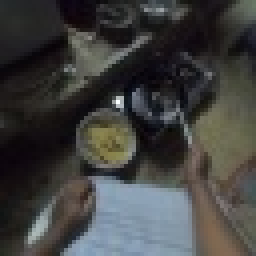

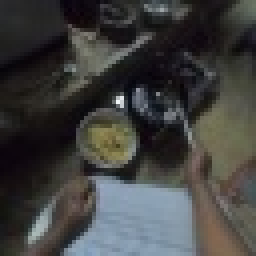

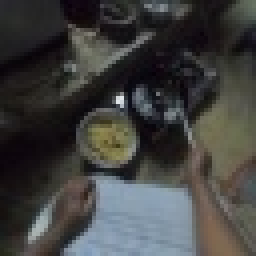

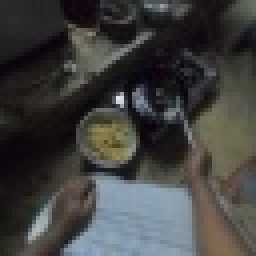

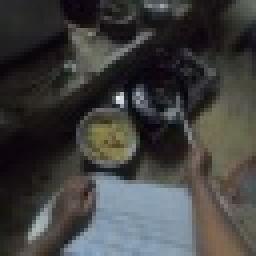

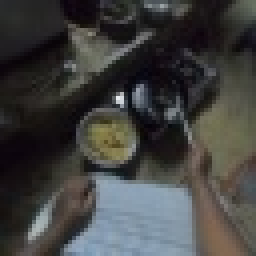

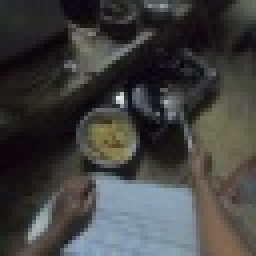

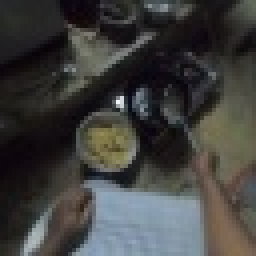

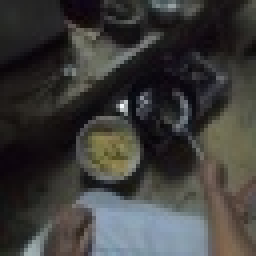

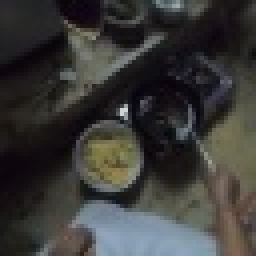

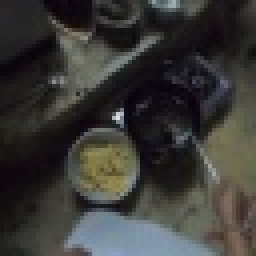

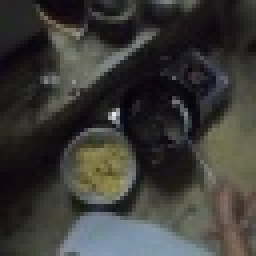

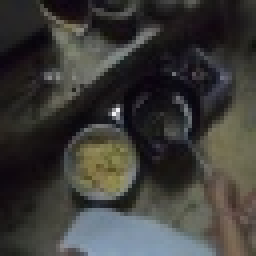

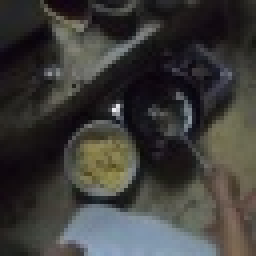

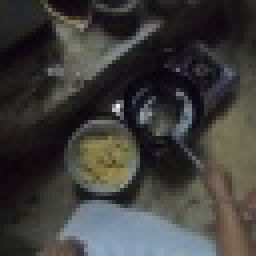

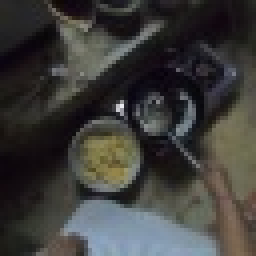

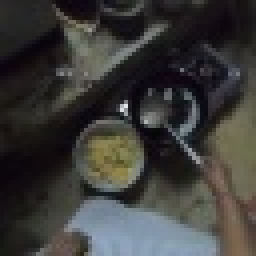

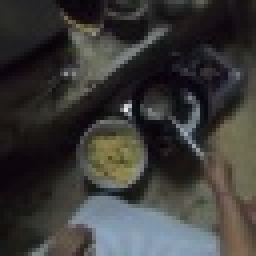

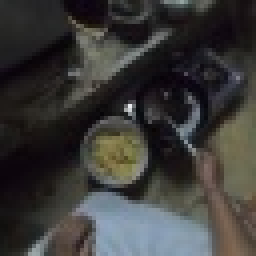

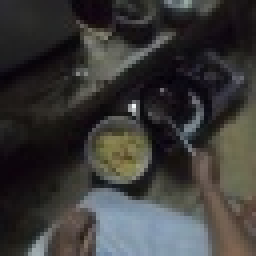

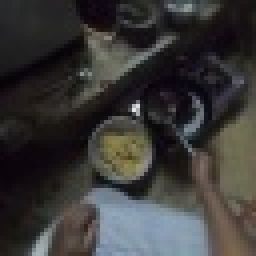

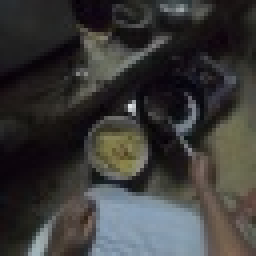

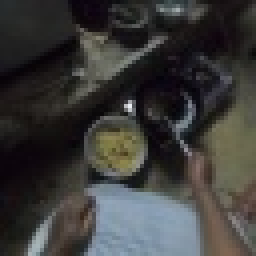

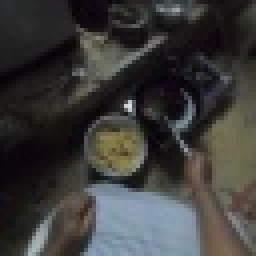

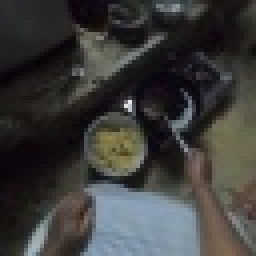

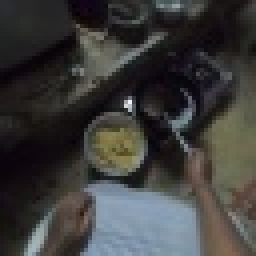

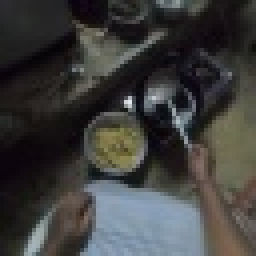

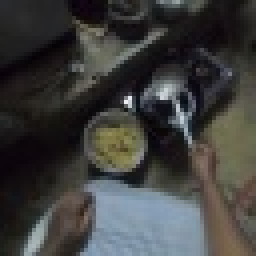

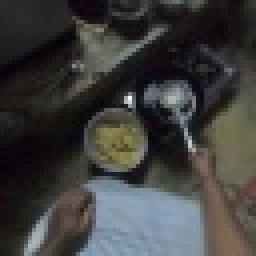

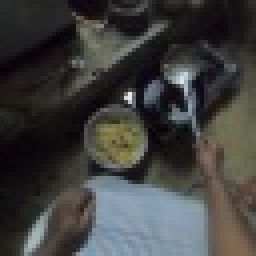

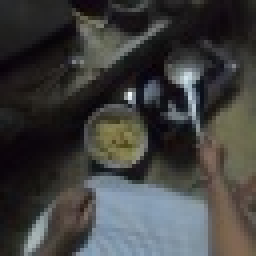

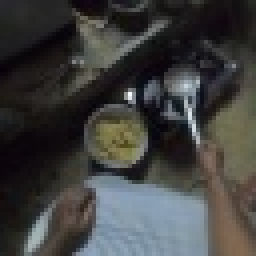

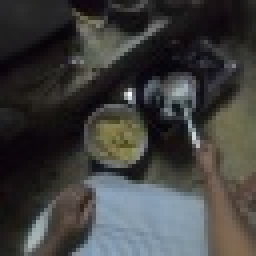

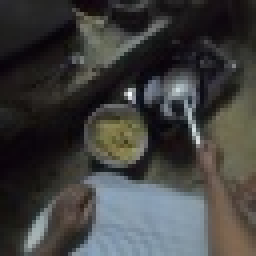

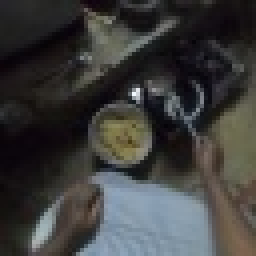

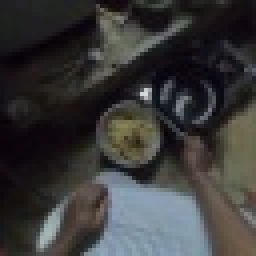

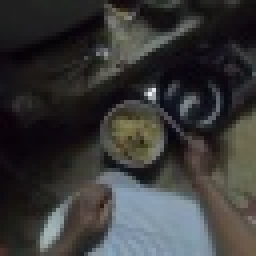

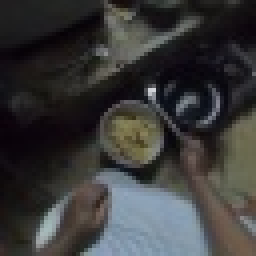

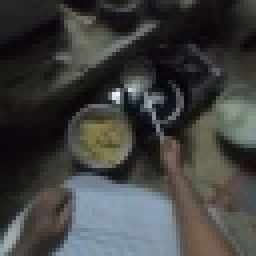

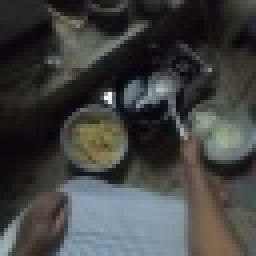

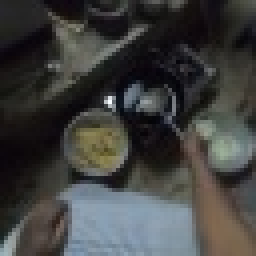

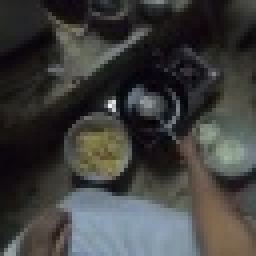

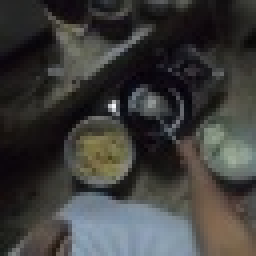

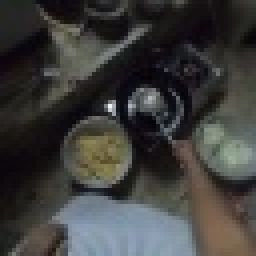

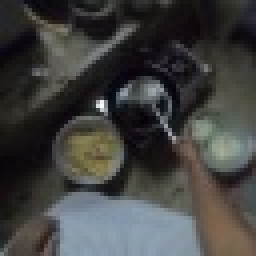

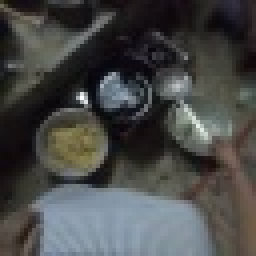

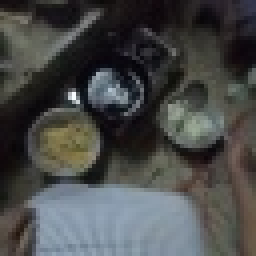

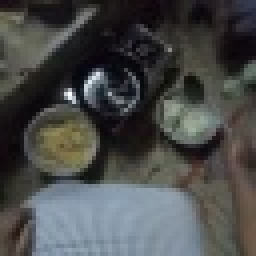

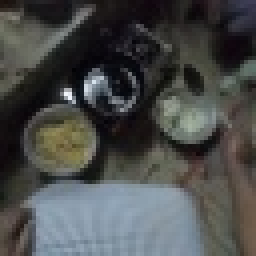

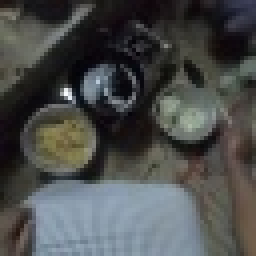

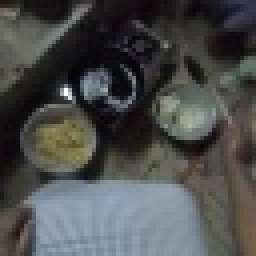

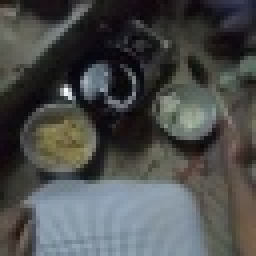

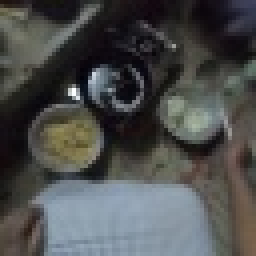

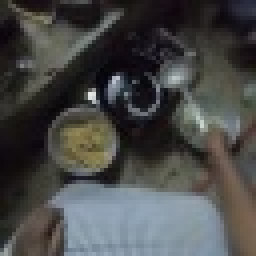

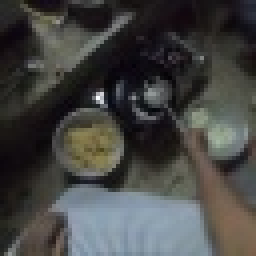

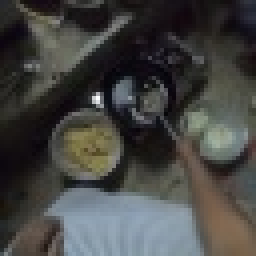

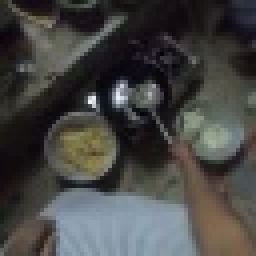

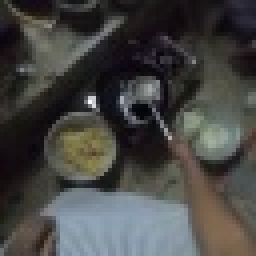

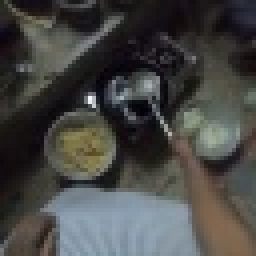

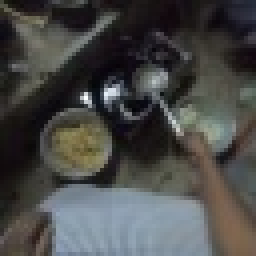

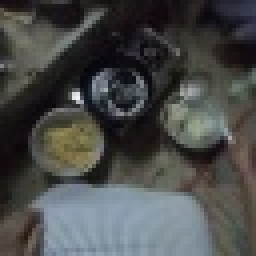

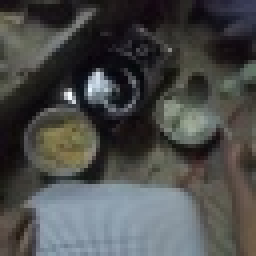

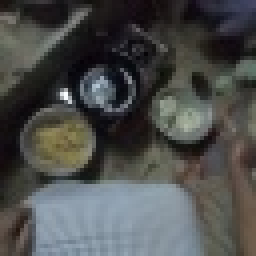

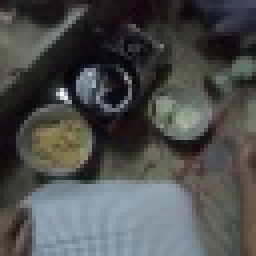

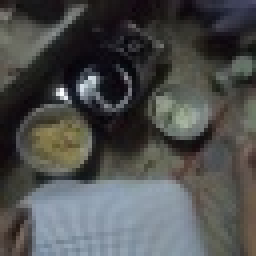

In [32]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

# manifest = json.load(open('/shared/group/ego4d/v1/annotations/moments_train.json'))
# vidid2vid = {}
# i = 0
# for vid in manifest['videos']:
#     vidid2vid[vid['video_uid']] = vid
#     i += 1
#     if i == 100:
#         break

datapath = "/home/ademi_adeniji/ego4dclips/" 
vid = data_path + 'c0e4d122-e7a9-4ed7-ac53-691906a43116'
for i in range(0, 1000, 10):
    image = torchvision.io.read_image(f"{vid}/{i}.jpg")
    show_images_ego4d(image, size=(256, 256))


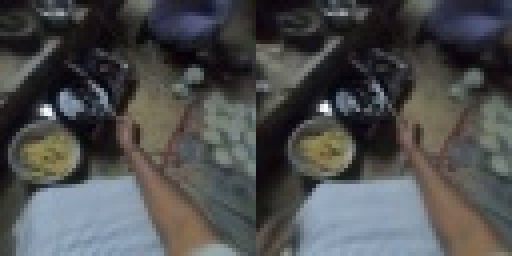

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

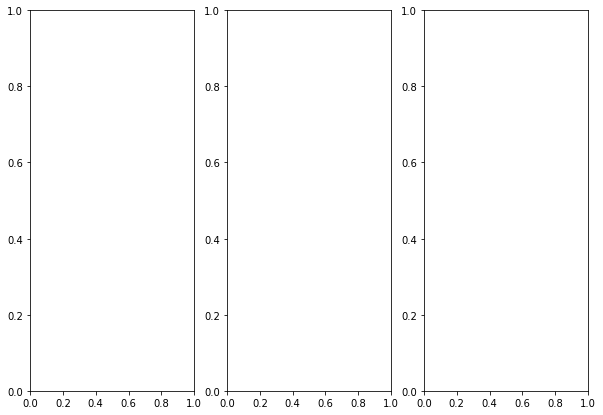

In [39]:
import numpy as np
from PIL import Image, ImageSequence
from r3m.utils.data_loaders import R3MBuffer
import pandas as pd
import torchvision
import pdb

datapath = "/home/ademi_adeniji/ego4dclips/"
vid = data_path + 'c0e4d122-e7a9-4ed7-ac53-691906a43116'
vidlen = 10
label = "mix food"
lang = np.array([label])
label_inv = "pour food"
label_alt = "put food in trash"
lang_inv = np.array([label_inv])
lang_alt = np.array([label_alt])
resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
start_image = torchvision.io.read_image(f"{vid}/{0}.jpg")
end_image = torchvision.io.read_image(f"{vid}/{vidlen-1}.jpg")
start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in range(vidlen):
    end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
    
show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0, 0].plot(rewards_scratch)
axs[0, 0].set(xlabel="num frames from start frame", ylabel="reward")
axs[0, 0].set_title("from scratch, " + label)

axs[0, 1].plot(rewards_scratch_inv)
axs[0, 1].set(xlabel="num frames from start frame", ylabel="reward")
axs[0, 1].set_title("from scratch, " + label_inv)

axs[0, 2].plot(rewards_scratch_alt)
axs[0, 2].set(xlabel="num frames from start frame", ylabel="reward")
axs[0, 2].set_title("from scratch, " + label_alt)

fig.tight_layout()


In [ ]:
start = resize((end_image / 255.0).unsqueeze(0)) * 255.0
start_scratch = r3m_scratch(start.to('cuda:0'))
rewards_scratch = []
rewards_scratch_inv = []
rewards_scratch_alt = []
for index in reversed(range(vidlen)):
    end = torchvision.io.read_image(f"{vid}/{index}.jpg")
    end = resize((end / 255.0).unsqueeze(0)) * 255.0
    end_scratch = r3m_scratch(end.to('cuda:0'))
    rewards_scratch.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
    rewards_scratch_inv.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
    rewards_scratch_alt.append(r3m_scratch.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())
print(f"video id: {vidid}")

show_images_rlbench(torch.stack([end_image, start_image]), size=(512, 256))
fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
axs[0, 0].plot(rewards_scratch)
axs[0, 0].set(xlabel="num frames from end frame", ylabel="reward")
axs[0, 0].set_title("from scratch, " + label)

axs[0, 1].plot(rewards_scratch_inv)
axs[0, 1].set(xlabel="num frames from end frame", ylabel="reward")
axs[0, 1].set_title("from scratch, " + label_inv)

axs[0, 2].plot(rewards_scratch_alt)
axs[0, 2].set(xlabel="num frames from end frame", ylabel="reward")
axs[0, 2].set_title("from scratch, " + label_alt)

fig.tight_layout()
